## Halotools Pipeline for SPARTA dataset ##
------------------------------------
This notebook is for carrying out the V+17 calculations (with some modification) on the Splashback Radius data provided by Benedikt Diemer.

In [1]:
# importing in all necessary libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.recfunctions import append_fields, merge_arrays
import scipy.stats as stats
import halotools.mock_observables as mo
import halotools.sim_manager as sm
import seaborn as sns
import pandas as pd

In [2]:
# setting various properties for analysis
lbox=500.0    # size of simulation box
fixbins = 20  # number of bins we are dividing our halos among
cores = 48    # number of processor cores we are running with

# setting various constants for analysis
gnewton = 4.302e-6 # units for calculating vmax/v200b

# the dictionary of important properties of interest for the ROCKSTAR 
# read in
# format is: 'name_of_property':(column_of_property, 'formatting_code')
rs_dict = {'halo_id':(1,'i8'), 'halo_spartastatus':(80,'f8'), 
           'halo_uidsplash':(86,'i8'), 'halo_masssplash':(84,'f8'),
           'halo_uidsplash87':(96,'i8'),
           'halo_rsplash':(82, 'f8'), 'halo_mass200b':(10,'f8'), 
           'halo_r200b':(11,'f8'), 'halo_vmax':(16,'f8'),
           'halo_rs':(12,'f8'), 'halo_x':(17,'f8'), 'halo_y':(18,'f8'), 
           'halo_z':(19,'f8'), 'halo_spin':(26,'f8'),
           'halo_ctoa':(47,'f8'), 'halo_masssplash87':(99,'f8'),
           'halo_rsplash87':(97, 'f8'), 'halo_uid':(6,'i8')}

In [3]:
# We now need to read in the SPARTA catalog. The key information we need is for SPARTA to have run successfully.
# We can make cuts beyond that as we see fit.

# Location of SPARTA data. This should obviously be changed depending on where you are.
infile = '/data/shared/sims/diemerl0500/sparta/L0500_N1024_CPla_0.88534_mpeak.catalog'

# Restrict us to the most massive halos - this rules out excess subhalos
# These likely don't exist since SPARTA cannot run on small things anyway.

minmass = 1e13 # minimum M200b halo mass in Msun/h
maxmass = 1e14 # Use one order of magnitude in range; small mass dominates the statistics due to HMF

# Initialize the tabular reader.
# Note we only use halos with spartastatus marked; this rules out subhalos and low mass halos by definition.
reader = sm.TabularAsciiReader(infile, rs_dict, 
                               row_cut_eq_dict={'halo_spartastatus':0},
                               row_cut_min_dict={'halo_mass200b':minmass},
                               row_cut_max_dict={'halo_mass200b':maxmass})
temp_data = reader.read_ascii()


...Processing ASCII data of file: 
/data/shared/sims/diemerl0500/sparta/L0500_N1024_CPla_0.88534_mpeak.catalog
 
Total number of rows in detected data = 70096
Number of rows in detected header = 0 

... working on chunk 0 of 1
Total runtime to read in ASCII = 1.06 seconds




In [4]:
# Now we are going to add on some common 200b properties.
halo_cV200b = temp_data['halo_vmax']/np.sqrt(gnewton*temp_data['halo_mass200b']/temp_data['halo_r200b'])
halo_cNFW200b = temp_data['halo_r200b']/temp_data['halo_rs']

# and for comparison, adding two different values of cV
halo_cVsp50 = temp_data['halo_vmax']/np.sqrt(gnewton*temp_data['halo_masssplash']/temp_data['halo_rsplash'])
halo_cVsp87 = temp_data['halo_vmax']/np.sqrt(gnewton*temp_data['halo_masssplash87']/temp_data['halo_rsplash87'])

# Also uniform randoms for our error analysis down the pipe.
uniformrands = np.random.uniform(0,1,len(temp_data))

# Append these together into a master file for 200b properties.
master_data = append_fields(temp_data, ('halo_cV200b', 'halo_cVsp50', 'halo_cVsp87', 'halo_cNFW200b', 'err_rands'),
                                (halo_cV200b, halo_cVsp50, halo_cVsp87, halo_cNFW200b, uniformrands))

Let's do a couple of analysis plots of the underlying data. We'll need them for the paper anyway.
-----

In [5]:
# Let's put the information in a pandas dataframe so that we can use Seaborn and Pandas.
pddata = pd.DataFrame(data={'halo_M200b': master_data['halo_mass200b'],
                            'halo_logM200b': np.log10(master_data['halo_mass200b']),
                            'halo_Msp50': master_data['halo_masssplash'],
                            'halo_logMsp50': np.log10(master_data['halo_masssplash']),
                            'halo_Msp87': master_data['halo_masssplash87'],
                            'halo_logMsp87': np.log10(master_data['halo_masssplash87']),
                            'halo_r200b': master_data['halo_r200b'],
                            'halo_rsp50': master_data['halo_rsplash'],
                            'halo_rsp87': master_data['halo_rsplash87'],
                            'halo_cNFW200b': master_data['halo_cNFW200b'],
                            'halo_cV200b': master_data['halo_cV200b'],
                            'halo_cVsp50': master_data['halo_cVsp50'],
                            'halo_cVsp87': master_data['halo_cVsp87'],
                            'halo_ctoa': master_data['halo_ctoa'],
                            'halo_spin': master_data['halo_spin']})

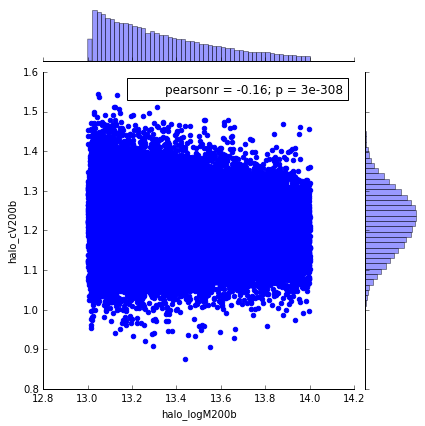

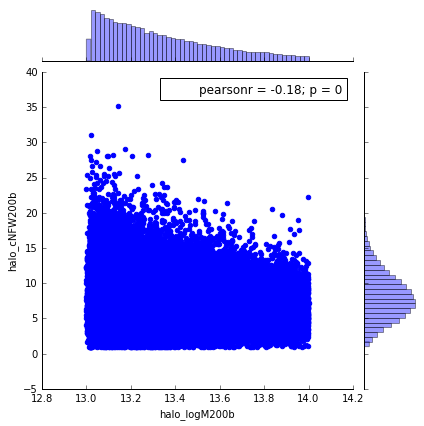

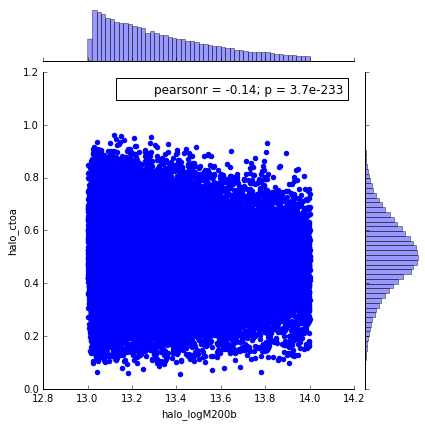

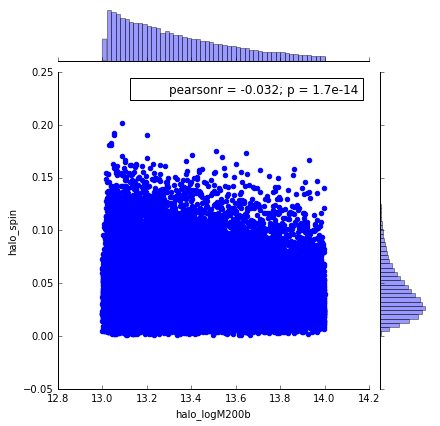

In [6]:
# One natural plot to make is to test the robustness of our halo properties. So let's look at concentration, shape, and
# spin against mass.

sns.jointplot('halo_logM200b', 'halo_cV200b', pddata)
sns.jointplot('halo_logM200b', 'halo_cNFW200b', pddata)
sns.jointplot('halo_logM200b', 'halo_ctoa', pddata)
sns.jointplot('halo_logM200b', 'halo_spin', pddata)

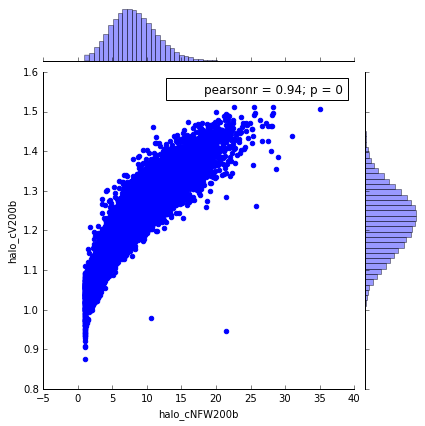

In [7]:
# And of course, comparing cNFW to cV never hurt.
sns.jointplot('halo_cNFW200b', 'halo_cV200b', pddata)

In [8]:
# Let's set some equally spaced bins instead of just using equally populated bins.
X1 = np.log10(master_data['halo_mass200b'])
bins = np.linspace(X1.min(), X1.max(), fixbins)   ## Note that this sets to equally spaced logmass bins.

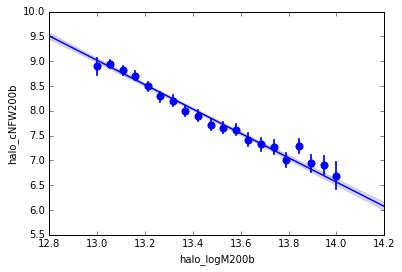

In [9]:
# First halo CNFW
sns.regplot('halo_logM200b', 'halo_cNFW200b', data=pddata, x_bins=bins)

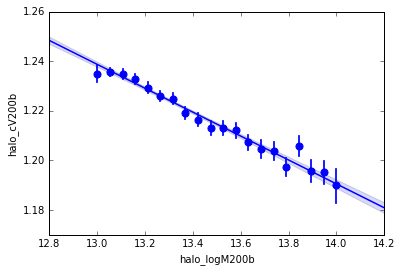

In [10]:
# Then halo cV
sns.regplot('halo_logM200b', 'halo_cV200b', data=pddata, x_bins=bins)

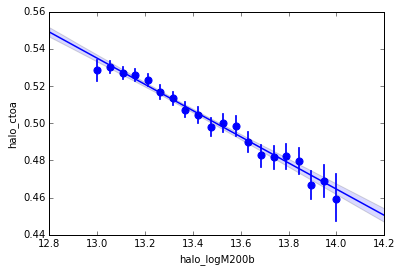

In [11]:
# Then halo shape
sns.regplot('halo_logM200b', 'halo_ctoa', data=pddata, x_bins=bins)

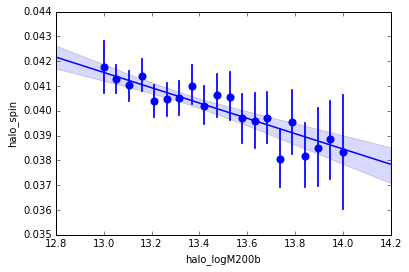

In [12]:
# Then halo spin
sns.regplot('halo_logM200b', 'halo_spin', data=pddata, x_bins=bins)

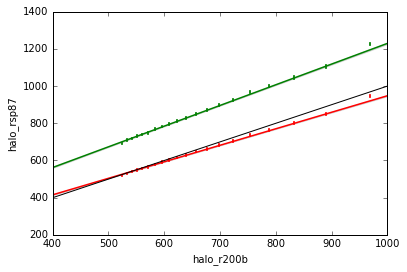

In [13]:
# And why not compare different halo radius for funsies.
sns.regplot('halo_r200b', 'halo_rsp50', data=pddata, x_bins=20, line_kws={'color':'r'}, scatter_kws={'alpha':0.0, 'color':'r'})
sns.regplot('halo_r200b', 'halo_rsp87', data=pddata, x_bins=20, line_kws={'color':'g'}, scatter_kws={'alpha':0.0, 'color':'g'})
x = range(400,1300)
plt.plot(x, x, 'k-')

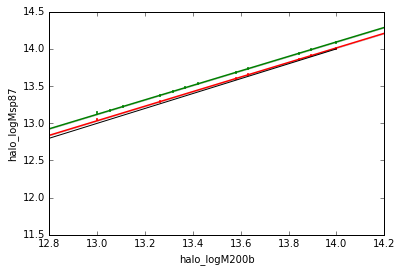

In [15]:
# And for the sake of completion, let's compare mass definitions too.
sns.regplot('halo_logM200b', 'halo_logMsp50', data=pddata, x_bins=bins, line_kws={'color':'r'}, scatter_kws={'alpha':0.0, 'color':'r'})
sns.regplot('halo_logM200b', 'halo_logMsp87', data=pddata, x_bins=bins, line_kws={'color':'g'}, scatter_kws={'alpha':0.0, 'color':'g'})
x = range(12,15)
plt.xlim(12.8,14.2)
plt.plot(x, x, 'k-')

## Mass Trend Removal ##
It is important to remove the underlying mass trends, so let's do that + some quick diagonistics here.

In [16]:
X1 = np.log10(master_data['halo_mass200b'])
bins = np.linspace(X1.min(), X1.max(), fixbins)   ## Note that this sets to equally spaced logmass bins.
idx = np.digitize(X1, bins)
for i in range(1, fixbins+1):
    ranks = np.zeros(len(master_data[idx==i]))
    ranks = stats.rankdata(master_data['halo_cV200b'][idx==i],'average')
    rank_fix = ranks / len(ranks)
    master_data['halo_cV200b'][idx==i]=rank_fix
    
    ranks = stats.rankdata(master_data['halo_cNFW200b'][idx==i],'average')
    rank_fix = ranks / len(ranks)
    master_data['halo_cNFW200b'][idx==i]=rank_fix
    
    ranks = stats.rankdata(master_data['halo_cVsp50'][idx==i],'average')
    rank_fix = ranks / len(ranks)
    master_data['halo_cVsp50'][idx==i]=rank_fix
    
    ranks = stats.rankdata(master_data['halo_cVsp87'][idx==i],'average')
    rank_fix = ranks / len(ranks)
    master_data['halo_cVsp87'][idx==i]=rank_fix
    
    ranks = stats.rankdata(master_data['halo_ctoa'][idx==i],'average')
    rank_fix = ranks / len(ranks)
    master_data['halo_ctoa'][idx==i]=rank_fix
    
    ranks = stats.rankdata(master_data['halo_spin'][idx==i],'average')
    rank_fix = ranks /len(ranks)
    master_data['halo_spin'][idx==i]=rank_fix

In [17]:
# Let's put the information in a pandas dataframe so that we can use Seaborn and Pandas.
rankdata = pd.DataFrame(data={'halo_M200b': master_data['halo_mass200b'],
                            'halo_logM200b': np.log10(master_data['halo_mass200b']),
                            'halo_Msp50': master_data['halo_masssplash'],
                            'halo_logMsp50': np.log10(master_data['halo_masssplash']),
                            'halo_Msp87': master_data['halo_masssplash87'],
                            'halo_logMsp87': np.log10(master_data['halo_masssplash87']),
                            'halo_r200b': master_data['halo_r200b'],
                            'halo_rsp50': master_data['halo_rsplash'],
                            'halo_rsp87': master_data['halo_rsplash87'],
                            'halo_cNFW200b': master_data['halo_cNFW200b'],
                            'halo_cV200b': master_data['halo_cV200b'],
                            'halo_ctoa': master_data['halo_ctoa'],
                            'halo_spin': master_data['halo_spin']})

(-0.5, 0.5)

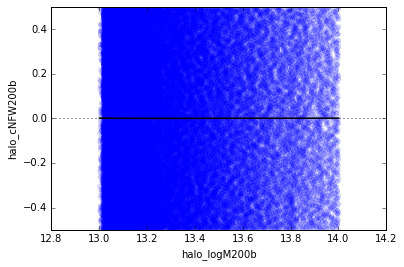

In [18]:
# Plot some residuals with a lowess smoother fit to determine if there is any structure remaining (this would be bad)
sns.residplot('halo_logM200b', 'halo_cNFW200b', data=rankdata, lowess=True, line_kws={'color':'k'},
              scatter_kws={'alpha':0.1, 'color':'b'})
plt.ylim(-0.5,0.5)

(-0.5, 0.5)

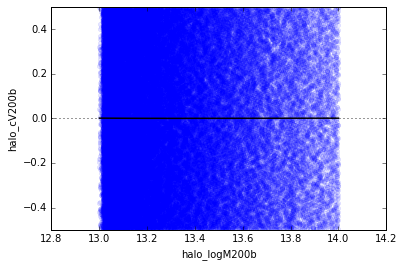

In [19]:
sns.residplot('halo_logM200b', 'halo_cV200b', data=rankdata, lowess=True, line_kws={'color':'k'},
              scatter_kws={'alpha':0.1, 'color':'b'})
plt.ylim(-0.5,0.5)

(-0.5, 0.5)

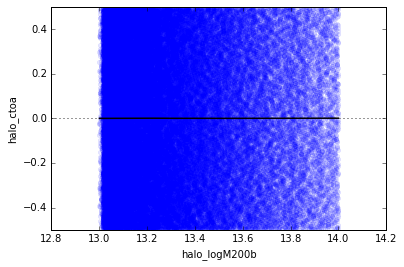

In [20]:
sns.residplot('halo_logM200b', 'halo_ctoa', data=rankdata, lowess=True, line_kws={'color':'k'},
              scatter_kws={'alpha':0.1, 'color':'b'})
plt.ylim(-0.5,0.5)

(-0.5, 0.5)

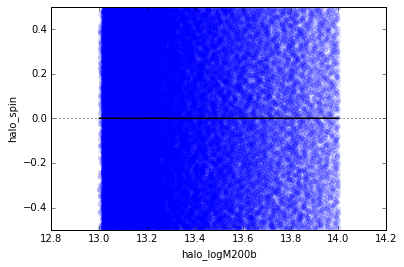

In [21]:
sns.residplot('halo_logM200b', 'halo_spin', data=rankdata, lowess=True, line_kws={'color':'k'},
              scatter_kws={'alpha':0.1, 'color':'b'})
plt.ylim(-0.5,0.5)

So as expected from our rank normalization, we have no remaining structure to the normalized data. Now any remaining relations SHOULD be solely driven by assembly bias.

## Marked Correlation Functional Analysis ##

We should now run the marked correlation function analysis for three different subsamples of the data:
1. uid = -1, representing a host halo in the r200b catalog.
2. uidsplash = -1, representing a host halo in the rsp50 catalog.
3. uidsplash87 = -1, representing a host halo in the rsp87 catalog.
The only change between these three is whether or not a halo is identified as a host halo or not, which we've identified as the dominant force in determining halo assembly bias (moreso than property changes.) For completeness, we should **also** use a comparison with cV from all three definitions, since this is a straightforward, profile free calculation.

In [22]:
# All of the calculations require positional data, so let's put that into a vector.
pos = np.vstack((master_data['halo_x'], master_data['halo_y'], master_data['halo_z'])).T

# And we define the box size.
lbox = 500.0

# And we set up the bins we calculated the MCF over. This matches V+17's method
nstep = 10
minlog = np.log10(3.0)
maxlog = np.log10(20.0)
steplog = (maxlog - minlog) / (nstep-1)
logbins = np.linspace(minlog, maxlog, num=nstep+1)
binmids = np.zeros(nstep)
for i in range(0,nstep):
    binmids[i] = (logbins[i]+logbins[i+1])/2.

# and then we'll need to normalize things to match V+17. Basically a uniform distribution to any reasonable metric.
mean = (1./2.)
var = (1./12.)

# Let's make a whole bunch of randomizations in order to actually tell how we are doing
nrand = 200
mcfn_rand = np.zeros((nstep,nrand))
for i in range(0, nrand):
    randerr = np.random.permutation(master_data['err_rands'])
    mcfn_rand[:,i] = (mo.marked_tpcf(pos, 10**logbins, marks1=randerr,
                                    period=lbox, normalize_by='number_counts',
                                    weight_func_id=1, num_threads=cores) -
                     mean**2)/var
    uppererr = [np.percentile(mcfn_rand[i,:],98) for i in range(nstep)]
    lowererr = [np.percentile(mcfn_rand[i,:],2) for i in range(nstep)]

In [23]:
# First let's calculate the MCF with regards to halo concentration. That's a good straightforward test.
mcf_cV200b = mo.marked_tpcf(pos, 10**logbins, marks1=master_data['halo_cV200b'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)


mcfn_cV200b = (mcf_cV200b - mean**2)/var

# We can also repeat this for the other two velocity concentrations real quick.
mcf_cVsp50 = mo.marked_tpcf(pos, 10**logbins, marks1=master_data['halo_cVsp50'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cVsp50 = (mcf_cVsp50 - mean**2)/var

mcf_cVsp87 = mo.marked_tpcf(pos, 10**logbins, marks1=master_data['halo_cVsp87'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cVsp87 = (mcf_cVsp87 - mean**2)/var

In [25]:
## That was for the WHOLE sample though. We should double check that these were all host halos (though they should be)
print 'Number of Host Halos by 200b: ', np.sum(np.where(master_data['halo_uid']==-1, 1, 0))
print 'Length of Data Set: ', len(master_data)
# This confirms that all of the Sparta data are host halos - not surprising by definition.
print 'Number of Host Halos by sp50: ', np.sum(np.where(master_data['halo_uidsplash']==-1, 1, 0))
print 'Number of Host Halos by sp87: ', np.sum(np.where(master_data['halo_uidsplash87']==-1, 1, 0))
# So some **small** changes in the population.

Number of Host Halos by 200b:  57246
Length of Data Set:  57246
Number of Host Halos by sp50:  56950
Number of Host Halos by sp87:  55653


In [26]:
# Now let's check how much of the impact is driven by change of property vs. change of population
splash50_data = master_data[np.where(master_data['halo_uidsplash']==-1)]
splash87_data = master_data[np.where(master_data['halo_uidsplash87']==-1)]

# And we'll need new positions for just these.
pos_sp50 = np.vstack((splash50_data['halo_x'], splash50_data['halo_y'], splash50_data['halo_z'])).T
pos_sp87 = np.vstack((splash87_data['halo_x'], splash87_data['halo_y'], splash87_data['halo_z'])).T

# And then we can calculate the cV marked correlation function for each of these, using the 200b properties.
mcf_cV200b_sp50 = mo.marked_tpcf(pos_sp50, 10**logbins, marks1=splash50_data['halo_cV200b'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cV200b_sp50 = (mcf_cV200b_sp50 - mean**2)/var

mcf_cV200b_sp87 = mo.marked_tpcf(pos_sp87, 10**logbins, marks1=splash87_data['halo_cV200b'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cV200b_sp87 = (mcf_cV200b_sp87 - mean**2)/var

# And we will also check to see if the change of properties AND the change of definition adds up to something.
mcf_cVsp50_sp50 = mo.marked_tpcf(pos_sp50, 10**logbins, marks1=splash50_data['halo_cVsp50'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cVsp50_sp50 = (mcf_cVsp50_sp50 - mean**2)/var

mcf_cVsp87_sp87 = mo.marked_tpcf(pos_sp87, 10**logbins, marks1=splash87_data['halo_cVsp87'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_cVsp87_sp87 = (mcf_cVsp87_sp87 - mean**2)/var

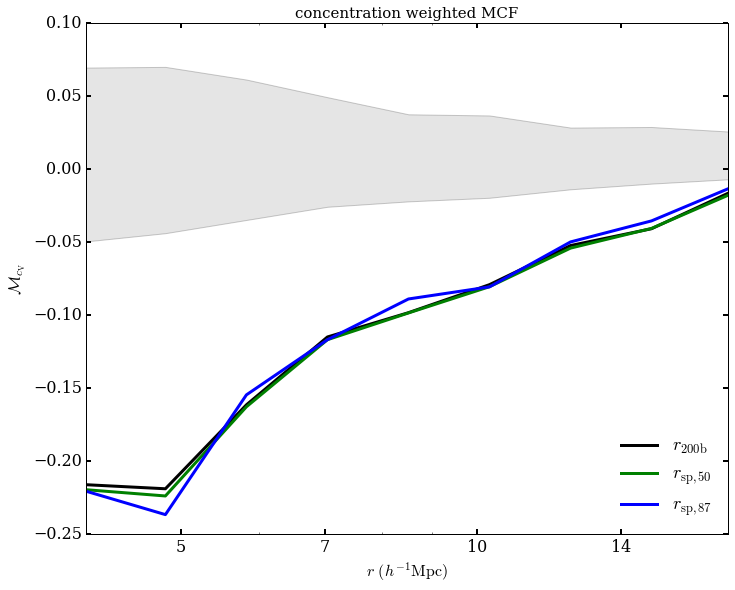

In [32]:
# And let's plot our data to make sure it is sane.

# Initialize some basic plotting stuff.
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3

titlesize=15
legsize=18

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

ax1.semilogx(10**binmids, mcfn_cV200b, 'k-', label='$r_{\mathrm{200b}}$')
ax1.semilogx(10**binmids, mcfn_cV200b_sp50, 'g-', label='$r_{\mathrm{sp,50}}$')
ax1.semilogx(10**binmids, mcfn_cV200b_sp87, 'b-', label='$r_{\mathrm{sp,87}}$')
ax1.fill_between(10**binmids, lowererr, uppererr, facecolor='grey', edgecolor='k', alpha=0.2)

ax1.set_xlim(4,18)
#ax1.set_ylim(-0.3,0.05)
ax1.set_xticks([5, 7, 10, 14])
ax1.set_xticklabels(['5', '7', '10', '14'])
ax1.tick_params(width=2, length=5)
ax1.set_xlabel(r'$r \ (h^{-1}\mathrm{Mpc})$')
ax1.set_ylabel(r'$\mathcal{M}_{c_\mathrm{V}}$')
ax1.set_title(r'concentration weighted MCF', fontdict={'fontsize': titlesize})


ax1.legend(loc='lower right',
           numpoints=1, prop={'size': legsize}, frameon=False)
fig.subplots_adjust(wspace=0)
fig.tight_layout(pad=0)
plt.savefig('./FIGS/sparta_cV.pdf')

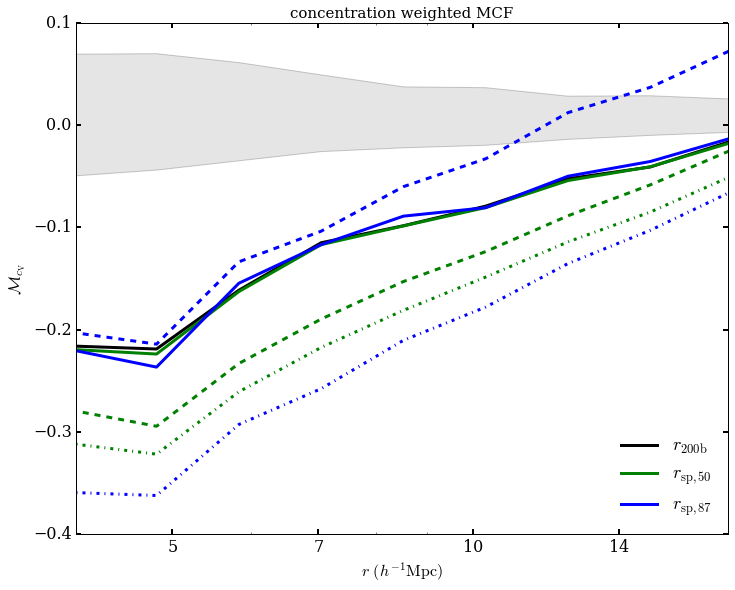

In [31]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

# Here are the plots using the 200b properties with different host definitions
ax1.semilogx(10**binmids, mcfn_cV200b, 'k-', label='$r_{\mathrm{200b}}$')
ax1.semilogx(10**binmids, mcfn_cV200b_sp50, 'g-', label='$r_{\mathrm{sp,50}}$')
ax1.semilogx(10**binmids, mcfn_cV200b_sp87, 'b-', label='$r_{\mathrm{sp,87}}$')

# We will also check using the new properties **AND** new host definitions.
ax1.semilogx(10**binmids, mcfn_cVsp50_sp50, 'g--')
ax1.semilogx(10**binmids, mcfn_cVsp87_sp87, 'b--')

# For completion, let's also plot on using the new properties **without** new host definitions.
ax1.semilogx(10**binmids, mcfn_cVsp50, 'g-.')
ax1.semilogx(10**binmids, mcfn_cVsp87, 'b-.')

ax1.fill_between(10**binmids, lowererr, uppererr, facecolor='grey', edgecolor='k', alpha=0.2)

ax1.set_xlim(4,18)
#ax1.set_ylim(-0.3,0.05)
ax1.set_xticks([5, 7, 10, 14])
ax1.set_xticklabels(['5', '7', '10', '14'])
ax1.tick_params(width=2, length=5)
ax1.set_xlabel(r'$r \ (h^{-1}\mathrm{Mpc})$')
ax1.set_ylabel(r'$\mathcal{M}_{c_\mathrm{V}}$')
ax1.set_title(r'concentration weighted MCF', fontdict={'fontsize': titlesize})


ax1.legend(loc='lower right',
           numpoints=1, prop={'size': legsize}, frameon=False)
fig.subplots_adjust(wspace=0)
fig.tight_layout(pad=0)
plt.savefig('./FIGS/sparta_cV_compare.pdf')

The logical conclusion to be drawn here is that the bulk of the impact on halo assembly bias is driven by the change of the halo properties: using different radius for cV RATHER than changing which halos are hosts vs subhalos. Interpretation remains. The combination of the two effects **DOES** have an intriguing impact:
1. Using the larger splashback radius but not changing host definition leads to a more negative assembly bias. Including the change to host definitions leads to a more positive assembly bias. This suggests that those halos that are closely grouped together
2. This impact is in the opposite direction as that of the *smaller* splashback radius. This implies that there is some fundamental balance between these two properties at work here. This is difficult to interpret.

In [28]:
# First our fiducial definition
mcf_ctoa = mo.marked_tpcf(pos, 10**logbins, marks1=master_data['halo_ctoa'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_ctoa = (mcf_ctoa - mean**2)/var

mcf_spin = mo.marked_tpcf(pos, 10**logbins, marks1=master_data['halo_spin'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_spin = (mcf_spin - mean**2)/var

# then the sp50 definition
mcf_ctoa_sp50 = mo.marked_tpcf(pos_sp50, 10**logbins, marks1=splash50_data['halo_ctoa'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_ctoa_sp50 = (mcf_ctoa_sp50 - mean**2)/var

mcf_spin_sp50 = mo.marked_tpcf(pos_sp50, 10**logbins, marks1=splash50_data['halo_spin'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_spin_sp50 = (mcf_spin_sp50 - mean**2)/var


# then the sp87 definition
mcf_ctoa_sp87 = mo.marked_tpcf(pos_sp87, 10**logbins, marks1=splash87_data['halo_ctoa'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_ctoa_sp87 = (mcf_ctoa_sp87 - mean**2)/var

mcf_spin_sp87 = mo.marked_tpcf(pos_sp87, 10**logbins, marks1=splash87_data['halo_spin'],
                           period=lbox, normalize_by='number_counts', weight_func_id=1,
                           num_threads=cores)
mcfn_spin_sp87 = (mcf_spin_sp87 - mean**2)/var

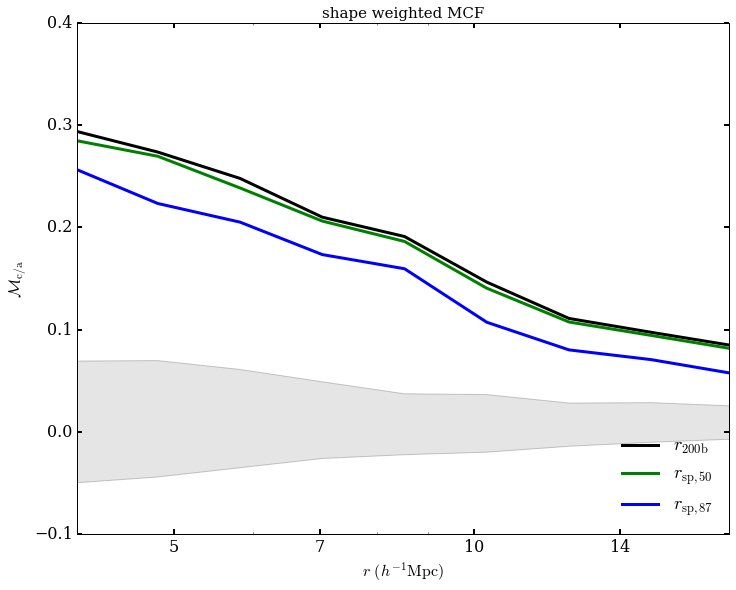

In [29]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

# Here are the plots using the 200b properties with different host definitions
ax1.semilogx(10**binmids, mcfn_ctoa, 'k-', label='$r_{\mathrm{200b}}$')
ax1.semilogx(10**binmids, mcfn_ctoa_sp50, 'g-', label='$r_{\mathrm{sp,50}}$')
ax1.semilogx(10**binmids, mcfn_ctoa_sp87, 'b-', label='$r_{\mathrm{sp,87}}$')

ax1.fill_between(10**binmids, lowererr, uppererr, facecolor='grey', edgecolor='k', alpha=0.2)

ax1.set_xlim(4,18)
#ax1.set_ylim(-0.3,0.05)
ax1.set_xticks([5, 7, 10, 14])
ax1.set_xticklabels(['5', '7', '10', '14'])
ax1.tick_params(width=2, length=5)
ax1.set_xlabel(r'$r \ (h^{-1}\mathrm{Mpc})$')
ax1.set_ylabel(r'$\mathcal{M}_{\mathrm{c/a}}$')
ax1.set_title(r'shape weighted MCF', fontdict={'fontsize': titlesize})

ax1.legend(loc='lower right',
           numpoints=1, prop={'size': legsize}, frameon=False)
fig.subplots_adjust(wspace=0)
fig.tight_layout(pad=0)
plt.savefig('./FIGS/sparta_ctoa.pdf')

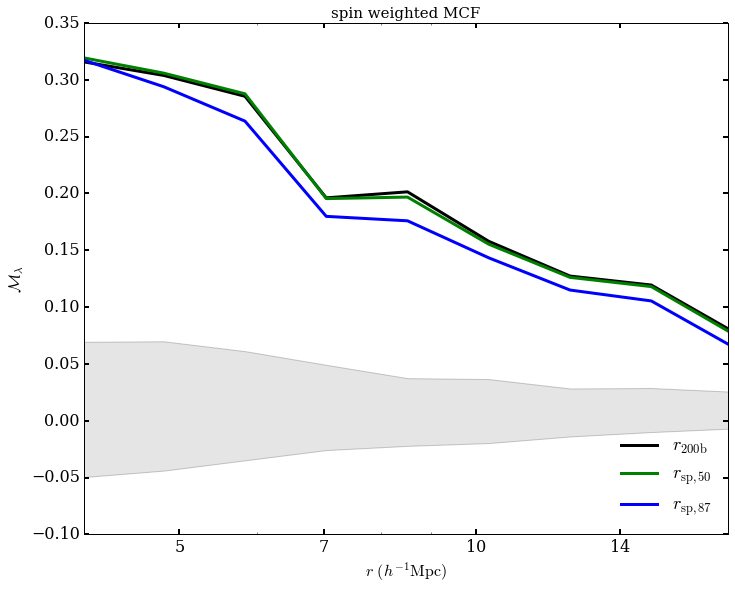

In [30]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

# Here are the plots using the 200b properties with different host definitions
ax1.semilogx(10**binmids, mcfn_spin, 'k-', label='$r_{\mathrm{200b}}$')
ax1.semilogx(10**binmids, mcfn_spin_sp50, 'g-', label='$r_{\mathrm{sp,50}}$')
ax1.semilogx(10**binmids, mcfn_spin_sp87, 'b-', label='$r_{\mathrm{sp,87}}$')

ax1.fill_between(10**binmids, lowererr, uppererr, facecolor='grey', edgecolor='k', alpha=0.2)

ax1.set_xlim(4,18)
#ax1.set_ylim(-0.3,0.05)
ax1.set_xticks([5, 7, 10, 14])
ax1.set_xticklabels(['5', '7', '10', '14'])
ax1.tick_params(width=2, length=5)
ax1.set_xlabel(r'$r \ (h^{-1}\mathrm{Mpc})$')
ax1.set_ylabel(r'$\mathcal{M}_{\lambda}$')
ax1.set_title(r'spin weighted MCF', fontdict={'fontsize': titlesize})

ax1.legend(loc='lower right',
           numpoints=1, prop={'size': legsize}, frameon=False)
fig.subplots_adjust(wspace=0)
fig.tight_layout(pad=0)
plt.savefig('./FIGS/sparta_spin.pdf')

## Big Finding Note ##
This is probably the most important result to interpret: note that as the size of the halo increases, the assembly bias signal of spin is reduced. This is the **opposite** behavior from what we noted in the 2017 paper.

//TODO: This isn't quite apples-to-apples. Verify that when only the halo definition is changed in our previous case, the direction remains consistent.